In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

Constants

In [2]:
PATH = 'train.csv'

In [3]:
df = pd.read_csv('train.csv')
prop0 = len(df[df.label == 0]) / len(df)
prop1 = len(df[df.label == 1]) / len(df)
prop2 = len(df[df.label == 2]) / len(df)

class_weights = np.exp(np.array([1-prop0, 1-prop1, 1-prop2]))
class_weights = class_weights / class_weights.sum()
class_weights = {0:0.6, 1:3.0, 2:0.75}

Data loading and preprocessing

In [4]:
def data_load_split(path=PATH, split_size=0.75):
    df = pd.read_csv(path)
    return train_test_split(
        df[['latitude', 'longitude', 'year', 'example_path']], 
        df.label, stratify=df.label, random_state=42, train_size=split_size
    )

def make_images(df: pd.DataFrame) -> list: #assuming the same structure as train.csv BUT without the 'label' column
    """
    This function creates an array of images from the paths in the train.csv
    """
    X = df.copy()
    paths = X.pop('example_path')
    
    images = []
    for p in paths:
        images.append(plt.imread(p))

    return np.array(X), np.array(images)

def augment_images(X: np.ndarray, y: np.ndarray, images:np.ndarray, rotate=True, mirror=True) -> list:
    """
    This function augments the existing image + metadata dataset 
    """
    transformations = []
    if rotate:
        transformations.extend([
            lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
            lambda x: cv2.rotate(x, cv2.ROTATE_180),
            lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE)
        ])
    
    if mirror:
        transformations.extend([
            lambda x: cv2.flip(x, 0),
            lambda x: cv2.flip(x, 1),
            lambda x: cv2.flip(x, -1)
        ])
    
    # add more transformations if needed
    
    img_augm = []
    for i in images:
        temp = [i]
        for func in transformations:
            temp.append(func(i))
        img_augm.append(temp)
    

    X_augm = []
    y_augm = []
    _img_augm = []
    for x, y, im in zip(X, y, img_augm):
        for i in im:
            X_augm.append(x)
            y_augm.append(y)
            _img_augm.append(i)

    return np.array(X_augm), np.array(y_augm), np.array(_img_augm)


Model creation and compilation

In [5]:
def make_model(optimizer='adam', metrics=['accuracy']):
    meta_input = tf.keras.layers.Input(shape=(3))
    image_input = tf.keras.layers.Input(shape=(332, 332, 3))

    # you can try to change layer parameters here
    image_data = tf.keras.layers.BatchNormalization()(image_input)
    image_data = tf.keras.layers.Conv2D(filters = 3, kernel_size=(3,3), strides=(3,3))(image_data)
    image_data = tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides=2)(image_data)
    image_data = tf.keras.layers.Conv2D(filters = 3, kernel_size=(3,3), strides=(3,3))(image_data)
    image_data = tf.keras.layers.Flatten()(image_data)

    meta_data = tf.keras.layers.BatchNormalization()(meta_input)

    data = tf.keras.layers.Concatenate()([meta_data, image_data])
    data = image_data

    data = tf.keras.layers.Dense(100, tf.nn.relu)(data)
    data = tf.keras.layers.Dense(3, tf.nn.softmax)(data)

    model = tf.keras.models.Model(inputs = [meta_input, image_input], outputs = [data])
    model.compile(
        optimizer, 
        'sparse_categorical_crossentropy', 
        metrics=metrics
    )
    # model.summary()
    return model

In [7]:
X_tr, X_val, y_tr, y_val = data_load_split()

X_tr_0 = X_tr[y_tr == 0]
X_tr_1 = X_tr[y_tr == 1]
X_tr_2 = X_tr[y_tr == 2]

X_tr_1, tr_1_images = make_images(X_tr_1)
X_tr_1, y_tr_1, tr_1_images = augment_images(X_tr_1, y_tr[y_tr == 1], tr_1_images, mirror=False)

X_tr_0, tr_0_images = make_images(X_tr_0)
X_tr_2, tr_2_images = make_images(X_tr_2)

X_tr = np.vstack([X_tr_0, X_tr_1, X_tr_2])
tr_images = np.vstack([tr_0_images, tr_1_images, tr_2_images])
y_tr = np.hstack([y_tr[y_tr == 0], y_tr_1, y_tr[y_tr == 2]])


X_val, val_images = make_images(X_val)

In [8]:
histories = []

for opt in ('adam', 'RMSprop', 'sgd'):
    model = make_model(optimizer=opt)
    histories.append(model.fit(
        [X_tr, tr_images],
        y_tr,
        validation_data=([X_val, val_images], y_val),
        verbose=True,
        epochs=10
    ))
    print(opt, model.evaluate([X_val, val_images], y_val))

Epoch 1/10
54/54 [==============================] - 41s 721ms/step - loss: 1.1904 - accuracy: 0.3673 - val_loss: 1.1109 - val_accuracy: 0.1538
Epoch 2/10
54/54 [==============================] - 38s 697ms/step - loss: 0.8659 - accuracy: 0.6292 - val_loss: 1.1631 - val_accuracy: 0.1375
Epoch 3/10
51/54 [===========================>..] - ETA: 2s - loss: 0.6424 - accuracy: 0.7641

KeyboardInterrupt: 

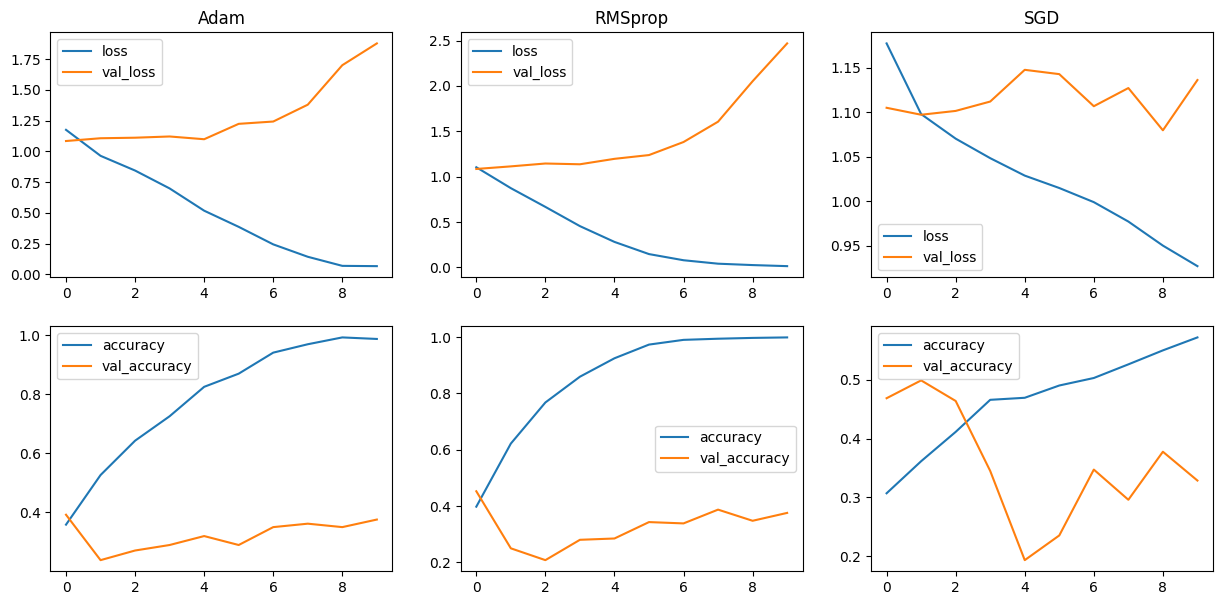

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,7))
opt = ['Adam', 'RMSprop', 'SGD']
for i in range(3):
    axs[0,i].plot(histories[i].history['loss'], label='loss')
    axs[0,i].plot(histories[i].history['val_loss'], label='val_loss')

    axs[1,i].plot(histories[i].history['accuracy'], label='accuracy')
    axs[1,i].plot(histories[i].history['val_accuracy'], label='val_accuracy')

    axs[0,i].set_title(opt[i])
    axs[0,i].legend()
    axs[1,i].legend()


In [9]:
model = make_model(optimizer=opt)
history = model.fit(
        [X_tr, tr_images],
        y_tr,
        validation_data=([X_val, val_images], y_val),
        verbose=True,
        epochs=10
    )

Epoch 1/10
54/54 [==============================] - 40s 724ms/step - loss: 1.1399 - accuracy: 0.3528 - val_loss: 1.0506 - val_accuracy: 0.5012
Epoch 2/10
54/54 [==============================] - 43s 798ms/step - loss: 0.9304 - accuracy: 0.5660 - val_loss: 1.0712 - val_accuracy: 0.4918
Epoch 3/10
54/54 [==============================] - 39s 723ms/step - loss: 0.7684 - accuracy: 0.6929 - val_loss: 1.1027 - val_accuracy: 0.3823
Epoch 4/10
54/54 [==============================] - 40s 745ms/step - loss: 0.5921 - accuracy: 0.8007 - val_loss: 1.0807 - val_accuracy: 0.3963
Epoch 5/10
54/54 [==============================] - 48s 894ms/step - loss: 0.3955 - accuracy: 0.8975 - val_loss: 1.1199 - val_accuracy: 0.3403
Epoch 6/10
54/54 [==============================] - 41s 749ms/step - loss: 0.2308 - accuracy: 0.9542 - val_loss: 1.1961 - val_accuracy: 0.3287
Epoch 7/10
54/54 [==============================] - 35s 650ms/step - loss: 0.1235 - accuracy: 0.9838 - val_loss: 1.3066 - val_accuracy: 0.3193

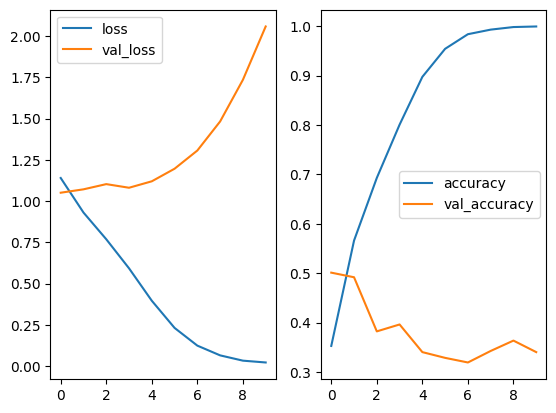

In [10]:
fig, axs = plt.subplots(1,2)
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')

axs[0].legend()
axs[1].legend()

In [11]:
df_test = pd.read_csv('test.csv')
X_test, images_test = make_images(df_test)

predictions = model.predict([X_test, images_test]).argmax(axis=-1)

preds = pd.DataFrame()
preds.index = df_test.index
preds['target'] = predictions

20/20 [==============================] - 1s 38ms/step


In [14]:
preds.to_csv("predictions.csv")
preds.to_json("predictions.json")